In [22]:
import requests

url = "https://alan-ptu.est.ai/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-21"
headers = {
    "Content-Type": "application/json",
    "api-key": "7ba4401f3ffa4e5d8d8e59e28c39d624"
}
data = {
    "messages": [
        {"role": "user", "content": "안녕, GPT-4o!"},
        {"role": "system", "content": "너는 유용한 AI 비서야."}
    ],
    "temperature": 0.7,
    "max_tokens": 100
}

response = requests.post(url, headers=headers, json=data)
print(response.status_code)
print(response.json())


200
{'id': 'chatcmpl-BTTkR5HCAVcdYpq9D69iEBNAYfIDz', 'object': 'chat.completion', 'created': 1746365563, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '안녕하세요! 저는 AI 비서 GPT-4o입니다. 어떻게 도와드릴까요?', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 29, 'completion_tokens': 21, 'total_tokens': 50, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'system_fingerprint': 'fp_ee1d74bde0'}


In [1]:
from langchain_openai import AzureChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()

llm = AzureChatOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    model="gpt-4o"
)
result = llm.invoke("안녕")

print(result)

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 9, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BTTc6qmbQdEaMJzWiqWTxb6Tq3WWm', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}} id='run-5c664614-5433-4c41-b0ff-0d4f92c32c43-0' usage_metadata={'input_tokens': 9, 'output_tokens': 12, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [2]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000275AD9CF770>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000275AD9E8050>, root_client=<openai.lib.azure.AzureOpenAI object at 0x00000275AD8852B0>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x00000275AD9CF8C0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), azure_endpoint='https://alan-ptu.est.ai/', openai_api_version='2024-10-21', openai_api_type='azure')

In [3]:
# 구조화된 출력을 위한 스키마
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="웹 검색에 최적화된 쿼리입니다.")
    justification: str = Field(
        None, description="이 쿼리가 사용자 요청과 어떤 관련이 있는지를 설명합니다."
    )
# 구조화된 출력을 위한 스키마로 LLM을 확장
structured_llm = llm.with_structured_output(SearchQuery, method="function_calling")

# 확장된 LLM을 호출
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# 도구 정의
def multiply(a: int, b: int) -> int:
    return a * b

# 도구로 LLM을 확장
llm_with_tools = llm.bind_tools([multiply])

# 도구 호출을 유도하는 입력으로 LLM 호출
msg = llm_with_tools.invoke("What is 2 times 3?")

# 도구 호출 결과 확인
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_YCj5rvGxjw5IU1Z1tajBuXR2',
  'type': 'tool_call'}]

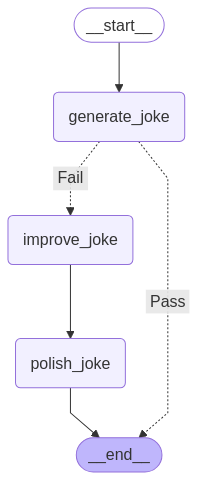

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Sure, here you go: 

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse and make sure it didn’t byte!

--- --- ---

Final joke:
Sure, here you go:

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse and make sure it didn’t byte! Little did it know, the mouse was actually an undercover agent from the Dog Intelligence Agency!


In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 상태 정의
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# 노드 정의
def generate_joke(state: State):
    """첫 번째 LLM 호출 - 초기 농담 생성"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate 함수 - 농담에 punchline이 있는지 검사"""
    # 간단한 검사 - "?" 또는 "!" 포함 여부 확인
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """두 번째 LLM 호출 - 농담 개선"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """세 번째 LLM 호출 - 농담 다듬기"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# 워크플로 구축
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# 노드 연결
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# 컴파일
chain = workflow.compile()

# 워크플로 시각화
display(Image(chain.get_graph().draw_mermaid_png()))

# 실행
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

In [5]:
state

{'topic': 'cats',
 'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!',
 'improved_joke': 'Sure, here you go: \n\nWhy was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse and make sure it didn’t byte!',
 'final_joke': 'Sure, here you go:\n\nWhy was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse and make sure it didn’t byte! Little did it know, the mouse was actually an undercover agent from the Dog Intelligence Agency!'}

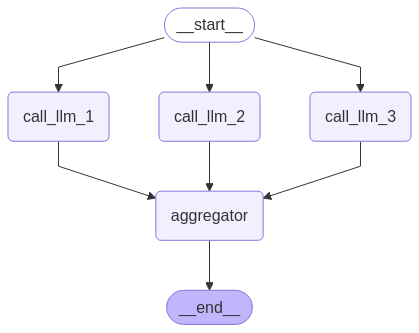

Here's a story, joke, and poem about cats!

STORY:
Once upon a time, in the heart of a bustling city, there was a quaint little bookstore called "Whiskers & Tales." This wasn't like any ordinary bookstore. It was a magical place, tucked away in a narrow alley, where the scent of aged paper mingled with that of freshly brewed coffee. But the real magic lay in its residents—four cats who were as much a part of the shop as the books themselves.

The eldest cat, Horatio, was a dignified black and white tuxedo cat with piercing green eyes. He had lived in the bookstore for as long as anyone could remember. Horatio had an uncanny ability to sense exactly what book a customer needed, even before they knew it themselves. His favorite spot was an old leather armchair by the fireplace, where he would curl up and occasionally raise his head to study the patrons with an air of wisdom.

Next was Luna, a sleek, silver tabby with a playful spirit. Luna adored the children's section and could often be

In [6]:
# 그래프 상태 정의
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# 노드 정의
def call_llm_1(state: State):
    """첫 번째 LLM 호출: 농담 생성"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """두 번째 LLM 호출: 이야기 생성"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """세 번째 LLM 호출: 시 생성"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """joke, story, poem을 하나의 출력으로 결합"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

# workflow 구성
parallel_builder = StateGraph(State)

# 노드 추가
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# 노드 간 연결 정의
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# 워크플로 시각화
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# 실행
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [7]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from PIL.Image import Image

# 구조화된 출력으로 routing 논리를 구현할 schema
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="Routing 프로세스의 다음 단계"
    )

# LLM에 schema를 적용하여 구조화된 출력 사용
router = llm.with_structured_output(Route, method="function_calling")

# 상태 정의
class State(TypedDict):
    input: str
    decision: str
    output: str

# 노드 정의
def llm_call_1(state: State):
    """이야기를 작성하는 노드"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """농담을 작성하는 노드"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """시를 작성하는 노드"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """입력을 적절한 노드로 라우팅"""

    # 구조화된 출력으로 라우팅 논리를 수행
    decision = router.invoke(
        [
            SystemMessage(
                content="사용자의 요청에 따라 입력을 story, joke, 또는 poem으로 라우팅하세요."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# 조건에 따라 다음 노드를 결정하는 edge 함수
def route_decision(state: State):
    # 다음 방문할 노드 이름을 반환
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

# 워크플로우 구성
router_builder = StateGraph(State)

# 노드 추가
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# 노드 연결
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# 워크플로우 컴파일
router_workflow = router_builder.compile()

# 실행 예시
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])


Sure, here's a cat joke for you:

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


### LangGraph에서 Worker 생성

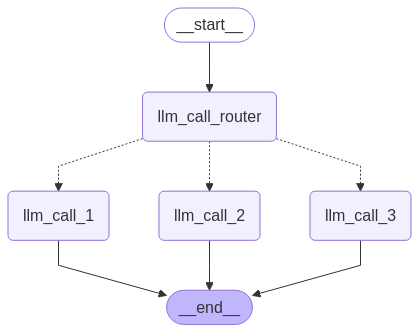

In [8]:
router_workflow

# Orchestrator-Worker

In [9]:
from typing import Annotated, List
import operator

# 계획 수립에 사용할 구조화된 출력용 schema
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# LLM을 구조화된 출력 스키마로 확장
planner = llm.with_structured_output(Sections, method="function_calling")


In [10]:
from langgraph.constants import Send

# 그래프 상태 정의
class State(TypedDict):
    topic: str  # 리포트 주제
    sections: list[Section]  # 리포트 섹션 목록
    completed_sections: Annotated[
        list, operator.add
    ]  # 모든 worker들이 이 key에 병렬로 작성
    final_report: str  # 최종 리포트

# Worker 상태 정의
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# 노드 정의
def orchestrator(state: State):
    """리포트 작성을 위한 계획을 수립하는 orchestrator"""

    # 쿼리 생성
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker가 섹션을 작성"""

    # 섹션 생성
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # 작성된 섹션을 completed_sections에 저장
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """모든 섹션을 종합하여 최종 리포트 생성"""

    # 작성 완료된 섹션 리스트
    completed_sections = state["completed_sections"]

    # 각 섹션을 문자열로 연결하여 최종 리포트 구성
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

### 조건 분기: worker들에게 섹션 분배

In [11]:
# 각 섹션별로 worker를 할당하는 조건 분기 함수
def assign_workers(state: State):
    """계획된 각 섹션에 worker 할당"""

    # Send API를 사용하여 섹션 작성 병렬 실행
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


### 전체 워크플로우 구축

In [12]:
# 워크플로우 빌더 초기화
orchestrator_worker_builder = StateGraph(State)

# 노드 추가
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# 노드 간 edge 설정
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# 워크플로우 컴파일
orchestrator_worker = orchestrator_worker_builder.compile()

# 실행 예시
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])


## Introduction and Description

In recent years, the development of large language models (LLMs) has drastically transformed the landscape of artificial intelligence (AI). A pivotal aspect underpinning this progress is the concept of scaling laws. Scaling laws refer to the predictable patterns and relationships that emerge as the size of a model's parameters, the amount of training data, or computational resources increase. Understanding these laws is critical for both researchers and practitioners, as they provide a foundational framework for designing and optimizing LLMs.

Scaling laws are integral to advancing AI research and applications for several reasons:

1. **Predictive Power**: Scaling laws facilitate the anticipation of how performance will improve with additional resources. By understanding these relationships, researchers can make informed decisions about the allocation of computational power, data collection efforts, and model architecture adjustments, leading to more efficient and effective models.

2. **Economic Efficiency**: AI development is resource-intensive. Scaling laws help identify the most cost-effective pathways to enhance model performance, ensuring that investments in hardware and data are proportionate to the expected gains.

3. **Guidance on Limits**: As models scale, they encounter different performance and capability limits. Scaling laws provide a theoretical underpinning to understand these boundaries, guiding researchers on when to pursue scaling versus when to innovate at the architectural level or through different training techniques.

4. **Benchmarking Progress**: The ability to measure AI advancements against scaling laws offers a systematic way to benchmark new models. This standardization allows the AI community to evaluate and compare progress in a structured manner, fostering collaborative and competitive advancements.

5. **Error Analysis and Debugging**: Understanding scaling laws can also aid in diagnosing errors and bottlenecks in model performance. Discrepancies from expected scaling behavior might reveal underlying issues in data quality, training procedures, or model design.

In summary, scaling laws are not just theoretical constructs but practical tools that drive the empirical advancements of LLMs. They enable a deeper understanding of the trade-offs, potentials, and limitations inherent in scaling AI systems, making them indispensable for the continued progression of AI technology and its applications.

---

## Theoretical Foundations

Scaling laws in machine learning provide a framework for understanding the relationships between various aspects of models, datasets, and computational resources, and how these relationships affect the performance and capabilities of large language models (LLMs).

### Model Size

One of the central concepts in scaling laws is model size, typically measured by the number of parameters in a model. Larger models have more parameters, which theoretically gives them the potential to learn more complex patterns and representations from data. Empirical studies have shown that, up to a point, increasing the number of parameters in LLMs generally improves their performance on a wide range of tasks, such as text generation, translation, and comprehension. This improvement follows a power-law relationship, where performance gains become progressively smaller as models grow larger, eventually reaching diminishing returns.

### Dataset Size

Dataset size is another crucial factor in scaling laws. The performance of LLMs tends to improve with the amount of training data available. Larger datasets help models learn more comprehensive and nuanced representations of language, making them more effective at capturing rare patterns and handling edge cases. However, similar to model size, the benefits of increasing dataset size also follow a power-law trend. After a certain point, the improvement per additional data point decreases, indicating that very large datasets are required to achieve marginal gains in performance in mature models.

### Computational Resources

The role of computational resources is intertwined with both model and dataset size. Training large models on extensive datasets requires significant computational power, often involving powerful GPUs or specialized hardware such as TPUs. Computational resources are not only essential for the initial training phase but also for fine-tuning and inference stages. They determine the feasibility and efficiency of developing and deploying LLMs. There's an exponential relationship between the size of the model and the resources required, meaning that as models and datasets grow, the computational costs increase significantly.

### Interaction Between Factors

The interaction between model size, dataset size, and computational resources creates a complex landscape where trade-offs must be carefully managed. Scaling laws suggest that there is an optimal balance that maximizes performance without incurring prohibitive resource costs. Researchers must consider this balance, often iteratively adjusting each factor to achieve the best possible outcomes. Moreover, advancements in algorithms, optimization techniques, and hardware can shift these relationships, enabling more efficient scaling of LLMs.

### Conclusion

Understanding the theoretical foundations of scaling laws is essential for guiding the development of LLMs. Model size, dataset size, and computational resources each play a pivotal role in shaping the capabilities of these models. By leveraging the insights provided by scaling laws, researchers can more effectively design and train LLMs to achieve state-of-the-art performance across various tasks.

---

## Empirical Evidence

### Studies and Experiments

**Kaplan et al. (2020)**: One of the cornerstone studies that provided robust evidence for scaling laws in large language models (LLMs) was conducted by Kaplan et al. This study meticulously analyzed the performance of transformer models as a function of model size, training data volume, and computational resources. The research demonstrated that as the number of parameters increases, model performance improves predictably, following a power-law relationship. Their experiments on models ranging from millions to billions of parameters showed significant gains in tasks such as language modeling and reading comprehension.

**Brown et al. (2020)**: The creators of the GPT-3 model showcased empirical evidence through extensive experimentation. GPT-3, boasting 175 billion parameters, drastically outperformed its predecessors on a multitude of NLP benchmarks like the superglue benchmark, zero-shot, and few-shot learning tasks. Brown et al. provided clear quantifiable improvements tying the model's scale directly to performance enhancements, empirically validating the scaling laws suggested by previous studies.

**Henighan et al. (2020)**: This study further built on existing theories by exploring the effects of both model scaling and dataset scaling. Their research with models scaling up to 10 billion parameters and datasets extending to 800GB showed that larger models continued to benefit from increased data, emphasizing a dual aspect of scaling laws – model size and data size. The evidence from their experiments underscored that optimal performance is achieved through balanced scaling of both elements.

### Real-World Examples

**OpenAI Codex**: With the commercial application of OpenAI's Codex, which powers GitHub Copilot, empirical evidence for scaling is observed in its practical utility. Codex is an advanced version of GPT-3 fine-tuned specifically for programming tasks. The model's performance in understanding and generating code in various languages illustrates the real-world efficacy of scaling laws. Its ability to handle intricate coding tasks reflects directly on the sophistication gained through model scaling.

**DeepMind’s Gopher Model**: In another notable example, DeepMind’s Gopher model, equipped with 280 billion parameters, showed marked improvements over smaller models in a variety of reading comprehension tasks and other language understanding benchmarks. Their empirical data indicated that for many tasks, Gopher significantly outperformed existing models, providing additional real-world evidence to the benefits of scaling.

**Anthropic’s Explorations**: Anthropic AI conducted extensive studies on scaling laws and robustly corroborated previous findings. Their work involved training models up to 100 billion parameters and analyzing performance jumps in terms of language understanding and generation capabilities. The documented incremental performance improvements provide convincing empirical support to the theoretical scaling laws.

### Summary

The presented empirical evidence strongly supports the validity of scaling laws in LLMs. Through various studies, including those by Kaplan et al., Brown et al., and Henighan et al., there’s a clear, demonstrable improvement in model performance with increased parameters and data. Real-world implementations, like OpenAI's Codex and DeepMind’s Gopher, further reinforce these findings, showing practical benefits of such scaling in diverse applications and industries.

---

## Challenges and Limitations

The process of scaling Large Language Models (LLMs) involves several intricate challenges and limitations that researchers and developers must navigate. Understanding these issues is critical for the informed advancement and practical application of these models.

### Computational Cost

One of the most significant challenges in scaling LLMs is the computational cost. Training state-of-the-art LLMs requires vast amounts of computational power, often relying on expensive specialized hardware such as GPUs or TPUs. This high computational demand translates to substantial financial costs, making it difficult for smaller organizations and independent researchers to participate in the development of LLMs. Additionally, the environmental impact of powering large-scale computational resources for extended periods raises ethical and sustainability concerns.

### Data Availability

Scalability is also heavily dependent on the availability of extensive and diverse datasets. For LLMs to generalize well and perform effectively across various tasks, they need to be trained on large volumes of high-quality data. However, sourcing such data can be problematic. Issues include data privacy concerns, the need for balanced representation of different languages and cultures, and the general difficulty in curating comprehensive datasets that avoid biases and inaccuracies. Data scarcity can lead to models that are less effective and potentially propagate harmful stereotypes or misinformation.

### Diminishing Returns

As LLMs become larger, the marginal improvements in performance begin to decrease, a concept known as diminishing returns. While initial increases in model size and complexity yield substantial gains in capabilities and accuracy, subsequent expansions often result in less significant enhancements. This plateau effect poses a challenge in justifying the continued investment of resources for seemingly incremental benefits. Researchers must weigh the trade-off between increased computational and data resource requirements against the actual performance gains achieved.

### Potential Problems and Trade-offs

Several problems and trade-offs emerge when addressing the challenges of scaling LLMs:

1. **Resource Allocation**: Balancing the allocation of computational resources between training new models and fine-tuning or deploying existing ones requires strategic decision-making. Organizations must determine the most effective use of their resources to meet their goals without overextending themselves.

2. **Model Interpretability**: Larger models are often more complex and less interpretable. This lack of transparency can be problematic when LLMs are applied in sensitive or high-stakes scenarios where accountability and understanding of decision-making processes are crucial.

3. **Ethical and Social Implications**: As LLMs gain more capabilities, ensuring their ethical use becomes increasingly important. There is a risk of misuse in generating harmful or deceptive content, as well as exacerbating biases present in training data. Researchers must develop strategies to mitigate these risks while balancing innovation with responsibility.

4. **Infrastructure and Maintenance**: Maintaining the infrastructure needed for scaling LLMs, including data storage, computational capacity, and continuous updates, is complex and resource-intensive. Long-term sustainability and reliability of such infrastructure are critical concerns, particularly for smaller entities.

In conclusion, while scaling LLMs holds the potential for significant advancements in natural language processing and various applications, it is accompanied by substantial challenges and limitations. Addressing these issues requires careful consideration of computational costs, data availability, diminishing returns, and the associated trade-offs to ensure that the development of LLMs remains both viable and beneficial.

---

## Future Directions

The continuous evolution of Large Language Models (LLMs) is heavily influenced by ongoing research and innovative methodologies. This section outlines potential future directions for research and development in LLM scaling laws, focusing on emerging trends, new methodologies, and innovative approaches that could further enhance our understanding and application of scaling laws in AI.

### Emerging Trends

**1. Multi-Modal LLMs:** Future LLMs are likely to integrate multiple data modalities, such as text, vision, and audio. This multi-modal approach can lead to more robust and versatile models capable of understanding and generating human-like responses across different types of inputs.

**2. Efficient Model Scaling:** As computational resources become a limiting factor, there is a trend toward developing more efficient models. Techniques like model pruning, quantization, and knowledge distillation can significantly reduce model size and inference time without compromising performance.

**3. Continued Advances in Hardware:** The development of specialized AI accelerators and quantum computing holds the promise of scaling LLMs to unprecedented sizes. These advancements in hardware could enable the training of models that are currently computationally infeasible.

### New Methodologies

**1. Self-Supervised Learning:** Advancements in self-supervised learning techniques, where models learn from vast amounts of unlabeled data, could contribute significantly to the scaling of LLMs. This approach can enhance the model's ability to generalize from limited annotated data.

**2. Federated Learning:** Collaborative learning paradigms, such as federated learning, allow multiple institutions to train models collectively without sharing sensitive data. This methodology could aid in scaling LLMs in a privacy-preserving manner.

**3. Adaptive Computation:** Implementing adaptive computation strategies, where the model dynamically adjusts its resources based on the complexity of the input, can lead to more efficient LLMs. This approach may involve varying the number of layers or attention heads used during inference.

### Innovative Approaches

**1. Hierarchical Models:** Developing hierarchical models that break down complex tasks into simpler sub-tasks could enhance scaling. This modular approach allows different parts of the model to specialize and scale independently, potentially leading to more effective and scalable architectures.

**2. Human-in-the-Loop Systems:** Incorporating human feedback mechanisms into the training loop can help in fine-tuning LLMs more efficiently. Active learning strategies, where the model seeks human input on ambiguous or critical predictions, could improve the model's performance and scalability.

**3. Neurosymbolic Integration:** Combining neural networks with symbolic reasoning can harness the strengths of both paradigms. This integration could lead to more interpretable and scalable models, particularly for tasks requiring logical inference and reasoning.

### Conclusion

The future of LLM scaling laws is poised for significant advancements driven by emerging trends, novel methodologies, and innovative approaches. By continuing to explore these directions, researchers and developers can push the boundaries of what is possible with LLMs, leading to more powerful, efficient, and versatile AI systems.

---

## Conclusion

This report has comprehensively explored the significance of scaling laws in the context of Large Language Models (LLMs). We have discussed how scaling laws serve as a fundamental framework for understanding the growth and performance of LLMs. Key points include:

- **Understanding Scaling Laws**: Scaling laws provide critical insights into how models improve as they are scaled up in terms of parameters, data, and compute resources. This understanding helps in predicting performance and guiding the development of more efficient and effective models.

- **Efficiency and Performance**: Through scaling laws, researchers can optimize the allocation of computational resources and improve the overall efficiency of model training and deployment. This leads to better-performing models that require lower costs and resources.

- **Benchmarking and Progress**: Scaling laws offer a benchmark for comparing different LLMs and tracking the progress in AI research. By adhering to these laws, researchers can set realistic goals and milestones for future advancements in AI technology.

- **Generalization Capabilities**: The application of scaling laws highlights the importance of model size and training data in enhancing the generalization capabilities of LLMs. As models scale, their ability to generalize from training data to diverse real-world tasks improves significantly.

- **Economic and Ethical Implications**: Scaling laws also bring forth discussions on the economic and ethical implications of deploying extremely large models. Balancing size, performance, and responsible use becomes crucial as LLMs continue to grow.

The potential impact of scaling laws on the future of AI research and technology cannot be overstated. As we continue to scale LLMs, we unlock new possibilities for innovation, enabling more advanced applications in natural language processing, automated reasoning, and beyond. Scaling laws will remain a keystone in guiding the next generation of AI advancements, shaping a future where AI systems are more powerful, efficient, and aligned with human values.

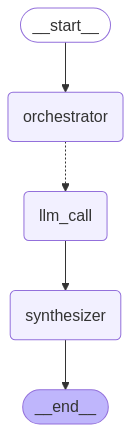

In [13]:
orchestrator_worker

## Evaluator-Optimizer

In [14]:
# Graph state 정의
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# 평가 시 사용할 structured output의 스키마 정의
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="이 농담이 웃긴지 아닌지를 결정하세요.",
    )
    feedback: str = Field(
        description="농담이 웃기지 않다면 어떻게 개선할 수 있을지 피드백을 작성하세요.",
    )

# structured output을 위해 LLM을 스키마로 보강
evaluator = llm.with_structured_output(Feedback, method="function_calling")

# 농담 생성 노드
def llm_call_generator(state: State):
    """LLM이 농담을 생성"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

# 농담 평가 노드
def llm_call_evaluator(state: State):
    """LLM이 농담을 평가"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# 평가 결과에 따라 다음 노드를 결정
def route_joke(state: State):
    """평가자 피드백을 기반으로 농담 생성기로 다시 라우팅할지 종료할지 결정"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

# 워크플로우 정의 및 구성
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# 워크플로우 컴파일 및 실행
optimizer_workflow = optimizer_builder.compile()
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why did the cat sit on the keyboard?  
To keep an eye on the mouse!


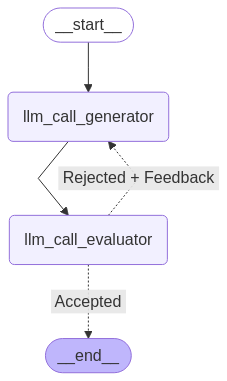

In [15]:
optimizer_workflow

## Agent

In [16]:
from langchain_core.tools import tool

# 도구 정의
@tool
def multiply(a: int, b: int) -> int:
    """a와 b를 곱합니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """a와 b를 더합니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """a를 b로 나눕니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a / b

# LLM에 도구 연결
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [17]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# 노드 정의
def llm_call(state: MessagesState):
    """LLM이 도구 호출 여부를 판단합니다."""
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """도구 호출을 수행합니다."""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# 조건 분기 함수 (도구 호출 여부에 따라 다음 노드를 결정)
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """LLM이 도구를 호출했는지에 따라 루프를 계속할지 결정합니다."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END


# 워크플로우 빌더 생성
agent_builder = StateGraph(MessagesState)

# 노드 추가
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# 노드 간 엣지 추가
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# 에이전트 컴파일
agent = agent_builder.compile()


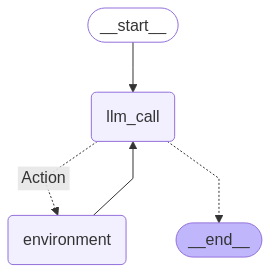

In [18]:
agent

In [19]:
# 에이전트 실행
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_nIAItcdjV1QZYJFkGU9ItSPI)
 Call ID: call_nIAItcdjV1QZYJFkGU9ItSPI
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [20]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_k6vRW58wAajp5k0Zmm9qblMZ)
 Call ID: call_k6vRW58wAajp5k0Zmm9qblMZ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


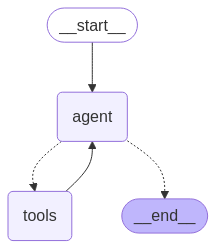

In [21]:
pre_built_agent